## A case for proper inference: bowel cancer incidence in the UK

In 2011 BBC published an article titled ['Three-fold variation' in UK bowel cancer death rates](https://www.bbc.com/news/health-14854019). As the title suggest, the article reports about a large variation in the relative number of deaths from bowel cancer across UK authorities. The numbers reported in the article are facts, but what we'd like to know is whether there is any real news here, statistically speaking. (Does this indicate a real difference in bowel cancer mortality between authorities?)

This analysis was first performed by a blogger XXXXX and I learned about it from David Spiegelhalter's wonderful book _The Art of Statistics_.

Consider the following thought experiment: let the incidence of bowel cancer in general population be $p \%$. What this means is that out of a 100 people we expect on average (footnote: whatever this means for the moment) $p$ will develop bowel cancer. To scale that up: for any number of people $n$, we expect that $n p / 100$ will develop bowel cancer. (footnote: we make an assumption that people develop cancer independently)

We can then simulate what would happen for $n$ people by flipping a biased coin for each one of them. Imagine we have a biased coin which comes up heads with probability $p$. For each of $n$ people, we flip the coin and declare they've go bowel cancer if the coin comes up tails. The sense in which $p \%$ is meant is that over a very large population we will have a proportion $p$ of bowel cancers, but for no finite population exactly $p$.

## Let's load some census data

We could make our point even with some fake numbers of people per authority, but we'll again use the occasion to play with some real data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pops = pd.read_csv("../data/bowel-cancer-raw.csv")
print(len(pops))
pops.isna().head(10)
pops = pops[pops.isna().Rate == False] # Removing the authorities with no report of rate
print(len(pops))

379
299


Text(0, 0.5, 'Population of the $k$th smallest authority')

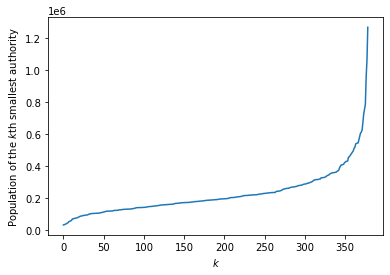

In [2]:
# Now we plot the sorted populations of each authority

plt.plot(pops.Population.sort_values())
plt.xlabel("$k$")
plt.ylabel("Population of the $k$th smallest authority")

In [2]:
pops

,Area,Rate,Population,Number
0,Shetland Islands,19.15,31332,6
1,Limavady,21.49,32573,7
2,Ballymoney,17.05,35191,6
3,Orkney Islands,29.87,36826,11
4,Larne,27.54,39942,11
...,...,...,...,...
374,Sheffield,16.90,757396,128
375,Durham,17.29,786582,136
376,Leeds,17.30,959538,166
377,Cornwall,15.44,1062176,164


In [3]:
print("Min population:", pops.Population.min())
print("Max population:", pops.Population.max())

Min population: 31332
Max population: 1268959


Let's start by showing the data. We plot bowel cancer rates per 100000 people.

In [3]:
rate = pops.Number.sum() / pops.Population.sum()
print("The estimated bowel cancer mortality across all areas is %0.4f" % (rate * 100), "\b%")

The estimated bowel cancer mortality across all areas is 0.0177 %


Text(0, 0.5, 'Bowel cancer deaths per 100000 people')

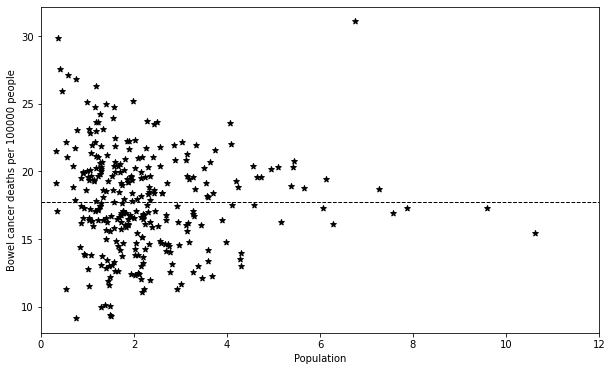

In [4]:
import seaborn as sns

fig = plt.figure(figsize=(10, 6))

plt.scatter(pops.Population / 1e5, 
            pops.Number / pops.Population * 1e5, 
            marker='*', 
            color='k'
           )
plt.plot([0, 12], [rate * 1e5, rate * 1e5], 'k--', linewidth=1)
plt.xlim([0, 12])
plt.xlabel("Population")
plt.ylabel("Bowel cancer deaths per 100000 people")

Now comes the core of the analysis. Assume (approximately correctly) that in a general population a fraction of $0.000176$ people will die of bowel cancer. This is less than 2 people in 10000 (we also make some independence assumptions, but don't worry about that for the moment).

We now simulate bowel cancer deaths by looking at each imaginary person in a given authority, tossing a very loaded coin which comes up heads with probability 0.000176, and declaring the person dead from bowel cancer if the coin comes up heads. We then count the number of deaths.


Text(0, 0.5, 'Bowel cancer deaths per 100000 people')

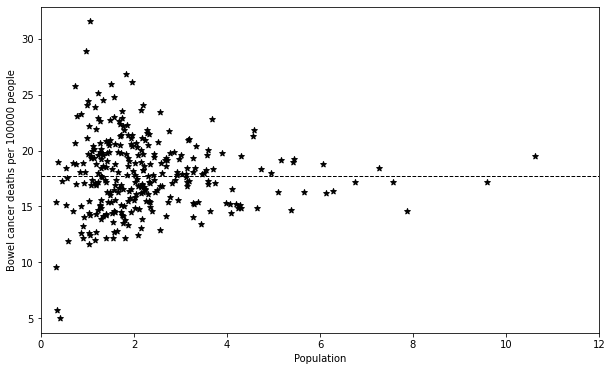

In [5]:
n_deaths = np.random.binomial(pops.Population, rate) \
           / pops.Population \
           * 1e5

fig = plt.figure(figsize=(10, 6))

plt.scatter(pops.Population / 1e5, n_deaths, marker='*', color='k')
plt.plot([0, 12], [rate * 1e5, rate * 1e5], 'k--', linewidth=1)
plt.xlim([0, 12])
plt.xlabel("Population")
plt.ylabel("Bowel cancer deaths per 100000 people")

This figure clearly shows that the variation in the number of deaths that results from randomness easily accounts for a three-fold variation in the number of deaths. 

The reason is that in smaller authorites we expect on average a small number of bowel cancer deaths. If an authority has 10000 people there will on average be (less than) 2 deaths. Thus 2 extra deaths due to chance already make for a two-fold variation.

Consider the following comparison: if you toss a fair coin 4 times, you will not be (too) surprised if the number of heads is anything between 0 and 4. But that is a huge relative variation! If you toss it 100 times, you expect that the number of heads is (relatively) close to 50. That's why in populous authorities the number of deaths is close to what we expect it to be (dashed line).

We can try to formalize this a bit further by making a funnel plot: we'll plot two pairs of lines—red and green, or two funnels with the following property: if we run the above random experiment many, many times, the result will be in the green funnel with probability 95% and in the red funnel with probability 99.7%. Again, don't worry about the calculations. We'll learn about this stuff soon.

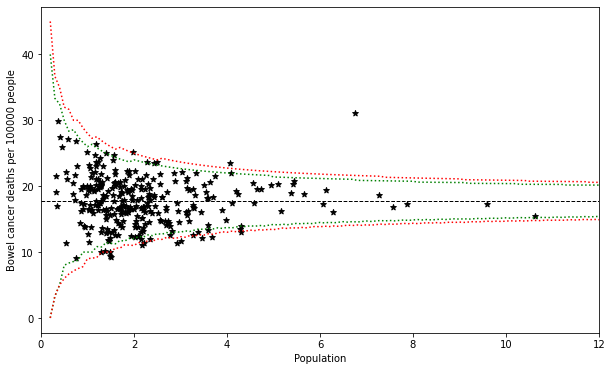

In [16]:
from scipy.stats import binom

pop_list = np.arange(2e4, 2e6, 1e4)

fig = plt.figure(figsize=(10, 6))

plt.scatter(pops.Population / 1e5, 
            pops.Number / pops.Population * 1e5, 
            marker='*', 
            color='k'
           )
plt.plot([0, 12], [rate * 1e5, rate * 1e5], 'k--', linewidth=1)
plt.xlim([0, 12])
plt.xlabel("Population")
plt.ylabel("Bowel cancer deaths per 100000 people")

marg_up = binom.ppf(0.975, pop_list, rate) / pop_list * 1e5
marg_down = binom.ppf(0.025, pop_list, rate) / pop_list * 1e5

plt.plot(pop_list / 1e5, marg_up, 'g:')
plt.plot(pop_list / 1e5, marg_down, 'g:')

marg_up = binom.ppf(0.99, pop_list, rate) / pop_list * 1e5
marg_down = binom.ppf(0.01, pop_list, rate) / pop_list * 1e5

plt.plot(pop_list / 1e5, marg_up, 'r:')
plt.plot(pop_list / 1e5, marg_down, 'r:')


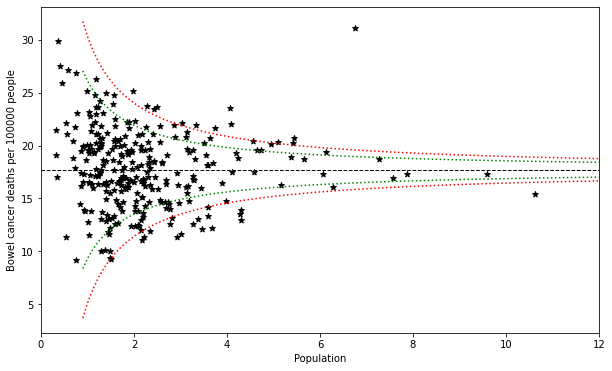

In [15]:
fig = plt.figure(figsize=(10, 6))

plt.scatter(pops.Population / 1e5, 
            pops.Number / pops.Population * 1e5, 
            marker='*', 
            color='k'
           )
plt.plot([0, 12], [rate * 1e5, rate * 1e5], 'k--', linewidth=1)
plt.xlim([0, 12])
plt.xlabel("Population")
plt.ylabel("Bowel cancer deaths per 100000 people")

pop_range = np.linspace(0.9, 12, 100)
sigma = np.sqrt(rate * (1 - rate) * 1e5)
mu = rate * 1e5

plt.plot(pop_range, mu + 2 * sigma / pop_range, 'g:')
plt.plot(pop_range, mu - 2 * sigma / pop_range, 'g:')
plt.plot(pop_range, mu + 3 * sigma / pop_range, 'r:')
plt.plot(pop_range, mu - 3 * sigma / pop_range, 'r:')

This is a stark example of the importance of sound _inference_. It is almost never appropriate to simply report the mean number of something, that is to say, a simple statistic. It should always be accompanied by an (un)certainty statement: based on careful analysis, what can we say about the reliability of this number?

It also shows the importance of statistical literacy. BBC is not some fringe online magazine but a reputable house. Yet they are not immune to bombastic, unsound proclamations.

## Exercises

1. Redo the above plots after increasing the rate 100 times. What can you say about the observed relative variation? Can you explain what you're seeing?

